In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def find_repo_root(marker="setup.py"):
    path = Path.cwd()
    while not (path / marker).exists() and path != path.parent:
        path = path.parent
    return path

project_root = find_repo_root()

data_dir = project_root/"data/results/cnn/"
figures_folder = project_root/"data/figures/cnn/"


In [19]:
# List of pruning range identifiers
variants = ["4down", "34", "23", "12", "05median", "05up"]
base_filename = "pruned_{}.xlsx"

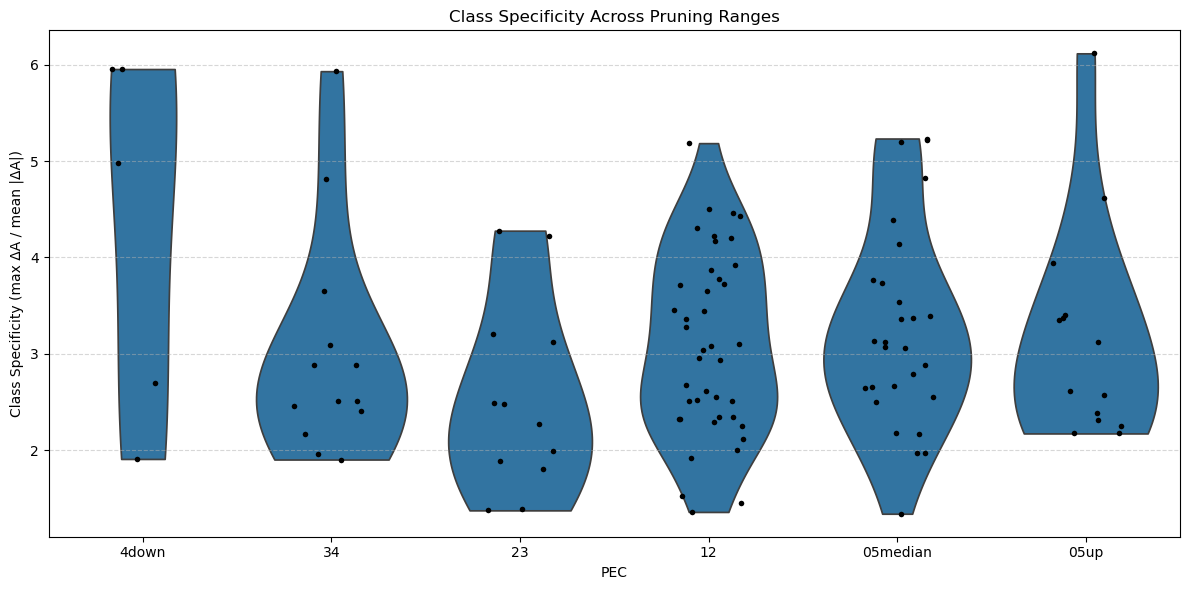

In [20]:
# Function to compute class specificity
def compute_class_specificity(df):
    delta_cols = [col for col in df.columns if col.startswith("Δ")]
    max_abs_delta = df[delta_cols].abs().max(axis=1)
    mean_abs_delta = df[delta_cols].abs().mean(axis=1)
    return max_abs_delta / mean_abs_delta


# Container for class specificity values
specificity_records = []

# Loop through each file
for variant in variants:
    file_path = os.path.join(data_dir, base_filename.format(variant))
    if not os.path.exists(file_path):
        print(f"Warning: File not found: {file_path}")
        continue

    df = pd.read_excel(file_path)
    df = df.iloc[1:]  # Drop the first row of data (keep headers)
    class_specificity = compute_class_specificity(df)

    for value in class_specificity:
        specificity_records.append({
            "PEC": variant,
            "Class Specificity": value
        })

specificity_df = pd.DataFrame(specificity_records)

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="PEC", y="Class Specificity", data=specificity_df, inner=None, cut=0)
sns.stripplot(x="PEC", y="Class Specificity", data=specificity_df, color="black", size=4, jitter=0.2)

plt.title("Class Specificity Across Pruning Ranges")
plt.ylabel("Class Specificity (max ΔA / mean |ΔA|)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



=== Dependency Stats for MaxMean ===
Pearson: 0.0268, p = 7.78e-01
Spearman: 0.1398, p = 1.40e-01
Mutual Info: 0.0535
Linear R²: 0.0007
Quadratic R²: 0.0309


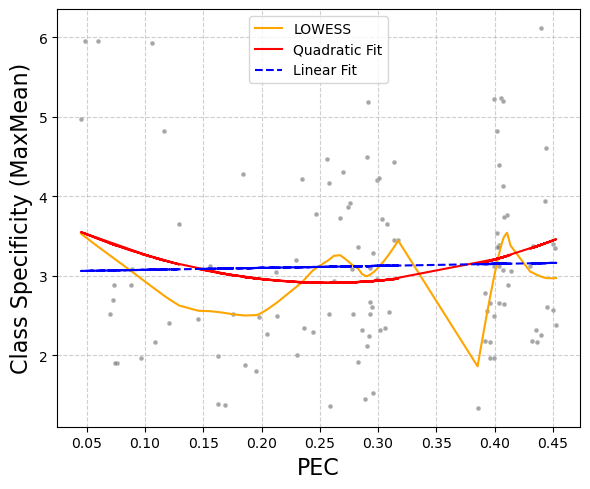

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import pearsonr, spearmanr, kendalltau

# Specificity metrics
def compute_max_mean(df):
    delta_cols = [col for col in df.columns if col.startswith("Δ")]
    max_val = df[delta_cols].abs().max(axis=1)
    mean_val = df[delta_cols].abs().mean(axis=1)
    return max_val / (mean_val + 1e-8)

def compute_top2_ratio(df):
    delta_cols = [col for col in df.columns if col.startswith("Δ")]
    sorted_abs = df[delta_cols].abs().apply(lambda row: sorted(row, reverse=True), axis=1)
    return sorted_abs.apply(lambda x: x[0] / (x[1] + 1e-8))

# PEC extractor
def extract_pec(subnet_str):
    try:
        floats = re.findall(r"[-+]?\d*\.\d+|\d+", subnet_str)
        return float(floats[-1]) if floats else None
    except Exception:
        return None

# Node pair PEC extractor
def extract_pair_pec(subnet_str):
    try:
        # Match only floats (e.g., 0.05, 1.23e-4)
        floats = re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?", subnet_str)
        return float(floats[0]) if floats else None
    except Exception:
        return None
    
# Net extractor
def extract_net(subnet_str):
    match = re.match(r"\(\((.*?)\),", subnet_str)
    if match:
        tuple_str = match.group(1)
        return tuple(map(int, tuple_str.split(',')))
    return None

# Specific class
def extract_specific_class(df):
    delta_cols = [col for col in df.columns if col.startswith("Δ")]
    max_class = df[delta_cols].abs().idxmax(axis=1)
    return max_class.str.replace("Δ", "", regex=False)


# Data aggregation
records = []

for variant in variants:
    file_path = data_dir / base_filename.format(variant)
    if not file_path.exists():
        print(f"File not found: {file_path}")
        continue

    df = pd.read_excel(file_path)
    df = df.iloc[1:]

    df["ClassSpec_MaxMean"] = compute_max_mean(df)
    df["ClassSpec_Top2"] = compute_top2_ratio(df)

    df["PEC"] = df["Subnet"].astype(str).apply(extract_pec)
    df["PairPEC"] = df["Subnet"].astype(str).apply(extract_pair_pec)

    df["Net"] = df["Subnet"].astype(str).apply(extract_net)
    df["Class"] = extract_specific_class(df)

    for _, row in df.iterrows():
        if pd.notna(row["PEC"]):
            records.append({
                "PEC": row["PEC"],
                "PairPEC": row["PairPEC"],
                "MaxMean": row["ClassSpec_MaxMean"],
                "Top2": row["ClassSpec_Top2"],
                "Net": row["Net"],
                "Class": row["Class"]
            })

plot_df = pd.DataFrame(records)

# Choose metric
metric = "MaxMean"  # Change to MaxMean, Gini, Top2 as needed

X = plot_df["PEC"].values.reshape(-1, 1)
y = plot_df[metric].values

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x=plot_df["PEC"], y=plot_df[metric], color="gray", s=12, alpha=0.7)

# LOWESS
smoothed = lowess(y, X.flatten(), frac=0.3)
plt.plot(smoothed[:, 0], smoothed[:, 1], color="orange", label="LOWESS")

# Quadratic fit
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
model_quad = LinearRegression().fit(X_poly, y)
y_quad = model_quad.predict(X_poly)
plt.plot(X, y_quad, color="red", label="Quadratic Fit")

# Linear fit
model_lin = LinearRegression().fit(X, y)
y_lin = model_lin.predict(X)
plt.plot(X, y_lin, color="blue", linestyle="--", label="Linear Fit")

# Stats
pear, p_pear = pearsonr(plot_df["PEC"], plot_df[metric])
spear, p_spear = spearmanr(plot_df["PEC"], plot_df[metric])
mi = mutual_info_regression(X, y, discrete_features=False)
r2_quad = r2_score(y, y_quad)
r2_lin = r2_score(y, y_lin)

print(f"\n=== Dependency Stats for {metric} ===")
print(f"Pearson: {pear:.4f}, p = {p_pear:.2e}")
print(f"Spearman: {spear:.4f}, p = {p_spear:.2e}")
print(f"Mutual Info: {mi[0]:.4f}")
print(f"Linear R²: {r2_lin:.4f}")
print(f"Quadratic R²: {r2_quad:.4f}")

plt.xlabel("PEC", fontsize=16)
plt.ylabel(f"Class Specificity ({metric})", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

save_path = figures_folder / f"pec_vs_class_specificity_{metric.lower()}.png"
plt.savefig(save_path)
plt.show()


In [22]:
def extract_class_specific_nets(df, metric="Top2"):
    # Group by 'Class' and find row with max metric in each group
    idx = df.groupby('Class')[metric].idxmax()
    # Return the rows corresponding to those max metric values
    return df.loc[idx][['Class', 'Net', 'PEC', metric]]

# Extract Top2 class-specific nets
max_top2_subnet_df = extract_class_specific_nets(plot_df, metric="Top2")

# Extract MaxMean class-specific nets
max_mean_subnet_df = extract_class_specific_nets(plot_df, metric="MaxMean")

print("\nMax Top2 Subnet per Class")
print(max_top2_subnet_df)   

print("\nMax Mean Subnet per Class")
print(max_mean_subnet_df)



Max Top2 Subnet per Class
        Class                           Net       PEC      Top2
50    1 - one      (16, 27, 8, 9, 18, 4, 2)  0.290901  4.479203
74    2 - two          (21, 14, 27, 15, 24)  0.399371  1.739879
96  3 - three                   (0, 12, 21)  0.406761  1.753375
13   4 - four  (12, 10, 16, 21, 13, 28, 26)  0.116400  3.085540
44   5 - five                 (0, 9, 1, 18)  0.277894  1.777546
34  7 - seven              (16, 24, 27, 21)  0.262012  1.705447
0   8 - eight                     (9, 3, 5)  0.048793  3.290615
86   9 - nine                   (11, 15, 7)  0.404140  3.753992

Max Mean Subnet per Class
         Class                           Net       PEC   MaxMean
50     1 - one      (16, 27, 8, 9, 18, 4, 2)  0.290901  5.185341
107    2 - two                  (11, 13, 20)  0.450132  3.399958
112  3 - three               (16, 13, 0, 12)  0.443123  3.943277
13    4 - four  (12, 10, 16, 21, 13, 28, 26)  0.116400  4.816503
44    5 - five                 (0, 9, 1, 18) 

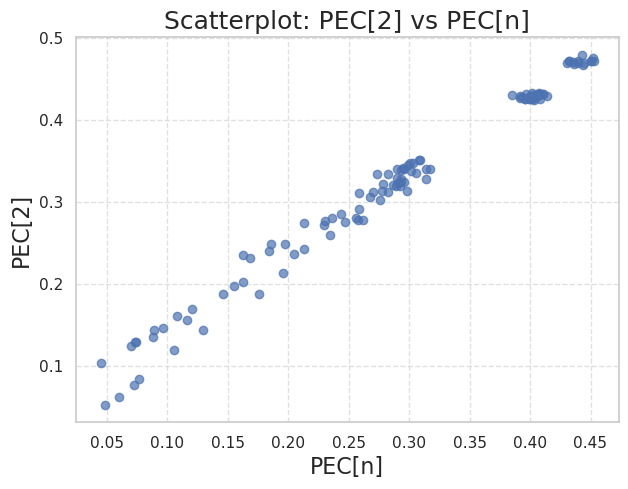

Pearson correlation: 0.9931
P-value: 3.0918e-105


In [28]:
from scipy.stats import pearsonr
sns.set(style="whitegrid")

# Scatter plot: PairPEC vs PEC
plt.figure(figsize=(7, 5))
plt.scatter(plot_df['PEC'], plot_df['PairPEC'], alpha=0.7)
plt.xlabel('PEC[n]', fontsize=16)
plt.ylabel('PEC[2]', fontsize=16)
plt.title('Scatterplot: PEC[2] vs PEC[n]', fontsize=18)
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig(figures_folder / "pec_pairpec_scatter.png", bbox_inches='tight', dpi=300)
plt.show()

# Pearson correlation
corr, p_value = pearsonr(plot_df['PEC'], plot_df['PairPEC'])
print(f"Pearson correlation: {corr:.4f}")
print(f"P-value: {p_value:.4e}")
